In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
import pickle
import plotly.express as px
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
import neurokit2 as nk
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 6)
plt.style.use('ggplot') # nicer plots
import os, re
from importlib import reload
import empatica_helpers as eh
import helpers as h

# eh.move_folders_to_root('input/empatica/')
# eh.rename_folders('input/empatica/')

dir_list = h.get_dir_list('input/empatica/')

print(dir_list)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x119002a50>>
Traceback (most recent call last):
  File "/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Preprocessing/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_49851/1141584813.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


['pp9-d2', 'pp5-d1', 'pp3-d2-1', 'pp7-d2-4', 'd1_1', 'pp5-d1-1', 'pp3-d2-7', 'pp7-d2-5', 'pp4-d2_1_1', 'd2_1_1', 'pp8-d2', 'pp3-d2_1', 'pp4-d1', 'd1', 'pp9-d1_1', 'pp3-d2', 'pp3-d1-1', 'pp10-d1', 'pp7-d1-2', 'pp7-d2', 'd2_1', 'pp4-d2_1', 'pp5-d2-1', 'pp5-d2-6', 'pp6-d2', 'pp4-d2-8', 'pp5-d2_1', 'pp2-d2', 'pp4-d2-9', 'pp4-d2-7', 'pp3-d1_1', 'pp11-d1', 'pp5-d2', 'pp3-d2-5', 'pp5-d2_1_1', 'pp3-d2-2', 'pp7-d2-7', 'd1_3', 'pp9-d1-2', 'd1_4', 'pp9-d1', 'pp3-d2-3', 'pp7-d2-6', 'pp7-d2-1', 'pp7-d2-8', 'pp5-d1-2', '1681717717_A03F6E', 'pp7-d2_1', '1681713254_A03F6E', 'pp4-d2', 'd2', 'pp8-d1', 'd2_4', 'pp10-d2', 'd1 2', 'pp3-d1', 'd2_2', 'pp5-d2-5', 'pp5-d2-2', 'pp7-d1', 'pp6-d1_1', 'pp7-d1_1', 'pp6-d1', 'pp4-d2-2', 'pp11-d2', 'pp4-d2-4', 'pp4-d2-3']


# Combining, upsampling, trimming raw data for EDA, BVP, TEMP and ACC

In [3]:
reload(h), reload(eh)

df = pd.DataFrame() 
ibi_df = pd.DataFrame()
trimmings_array = np.array([]) # Trimmings are the numbers of samples removed from dataframes coming from a single folder due to differing start or end times. 
uniqueness_check_df = pd.DataFrame()
no_ibi = 0
for folder in dir_list:
    temp, ibi, trimmings, uniqueness_check = eh.load_data_and_combine(f'input/empatica/{folder}', verbose = False, useIBI = True)
    # Concat to df if not empty
    if not temp.empty:
        trimmings_array = np.append(trimmings_array, trimmings)
        df = pd.concat([df, temp])
        uniqueness_check_df = pd.concat([uniqueness_check_df, uniqueness_check])
        ibi_df = pd.concat([ibi_df, ibi])
    else:
        print(f"Skipping {folder} due to empty dataframe.")
    if ibi is None:
        no_ibi += 1

print(f"Number of folders with no IBI data: {no_ibi} / {len(dir_list)}")

Skipping input/empatica/pp7-d2-4/IBI.csv because it is empty.
Skipping input/empatica/pp5-d1-1/IBI.csv because it is empty.
Skipping input/empatica/pp7-d2-5/IBI.csv because it is empty.
Skipping input/empatica/pp4-d2_1_1/HR.csv due to insufficient signal length.
Skipping input/empatica/pp4-d2_1_1/IBI.csv because it is empty.
Skipping input/empatica/pp3-d1-1/IBI.csv because it is empty.
Skipping input/empatica/pp7-d1-2/IBI.csv because it is empty.
Skipping input/empatica/pp4-d2_1/IBI.csv because it is empty.
Skipping input/empatica/pp5-d2-1/IBI.csv because it is empty.
Skipping input/empatica/pp5-d2-6/IBI.csv because it is empty.
Skipping input/empatica/pp4-d2-9/IBI.csv because it is empty.
Skipping input/empatica/pp4-d2-7/IBI.csv because it is empty.
Skipping input/empatica/pp3-d2-5/HR.csv due to insufficient signal length.
Skipping input/empatica/pp3-d2-5/IBI.csv because it is empty.
Skipping input/empatica/pp7-d2-7/IBI.csv because it is empty.
Skipping input/empatica/pp7-d2-6/IBI.csv

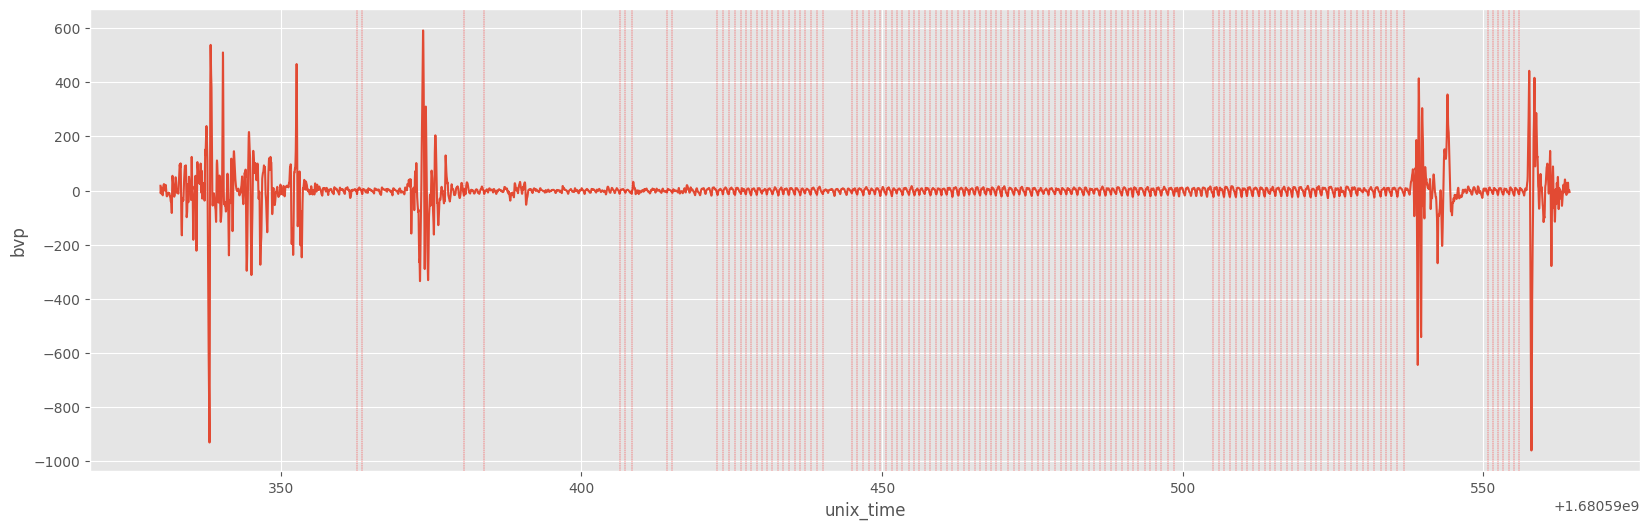

In [26]:
# Plot df['bvp'] and add vertical lines as markers for each value in df_ibi['unix_time'] using sns
fig, ax = plt.subplots()
sns.lineplot(data=df.iloc[0:15000], x='unix_time', y='bvp', ax=ax)

# Get the 'unix_time' of the 10000th sample in df
start_time = df.iloc[0]['unix_time']
end_time = df.iloc[14999]['unix_time']

# Iterate over ibi_df until 'unix_time' reaches end_time
for idx, row in ibi_df.iterrows():
    if row['unix_time'] > end_time:
        break
    if row['unix_time'] >= start_time:
        plt.axvline(row['unix_time'], color='r', linestyle='--', alpha=1, linewidth=0.3)

plt.show()

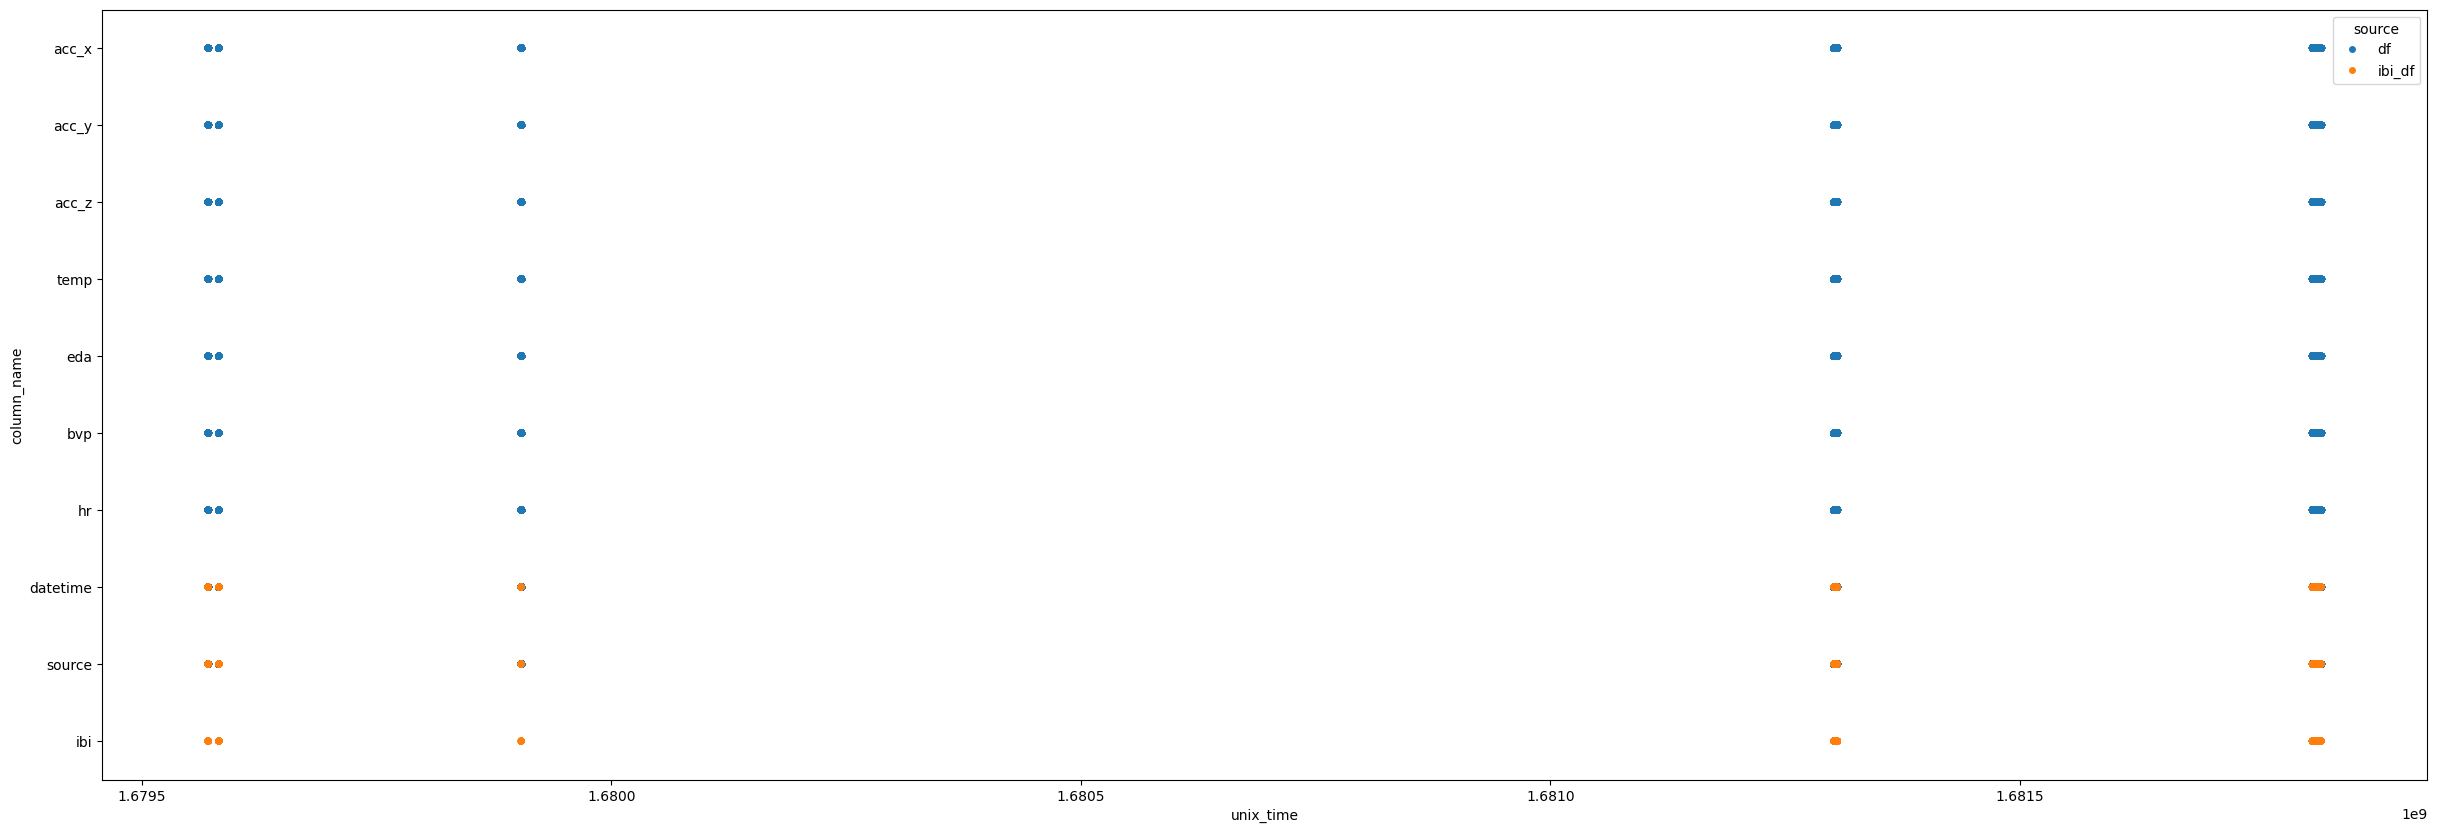

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt df
df_melted = df.melt(id_vars='unix_time', var_name='column_name')

# Melt ibi_df
ibi_df_melted = ibi_df.melt(id_vars='unix_time', var_name='column_name')

# Add a 'source' column to distinguish between the two DataFrames
df_melted['source'] = 'df'
ibi_df_melted['source'] = 'ibi_df'

# Concatenate the two melted DataFrames
combined_melted = pd.concat([df_melted, ibi_df_melted])

# Plot
plt.figure(figsize=(30, 10))
sns.stripplot(x='unix_time', y='column_name', hue='source', data=combined_melted, jitter=False)
plt.show()

# Data cleaning

## Dataframe trimming

### Number of trimmed samples

[]


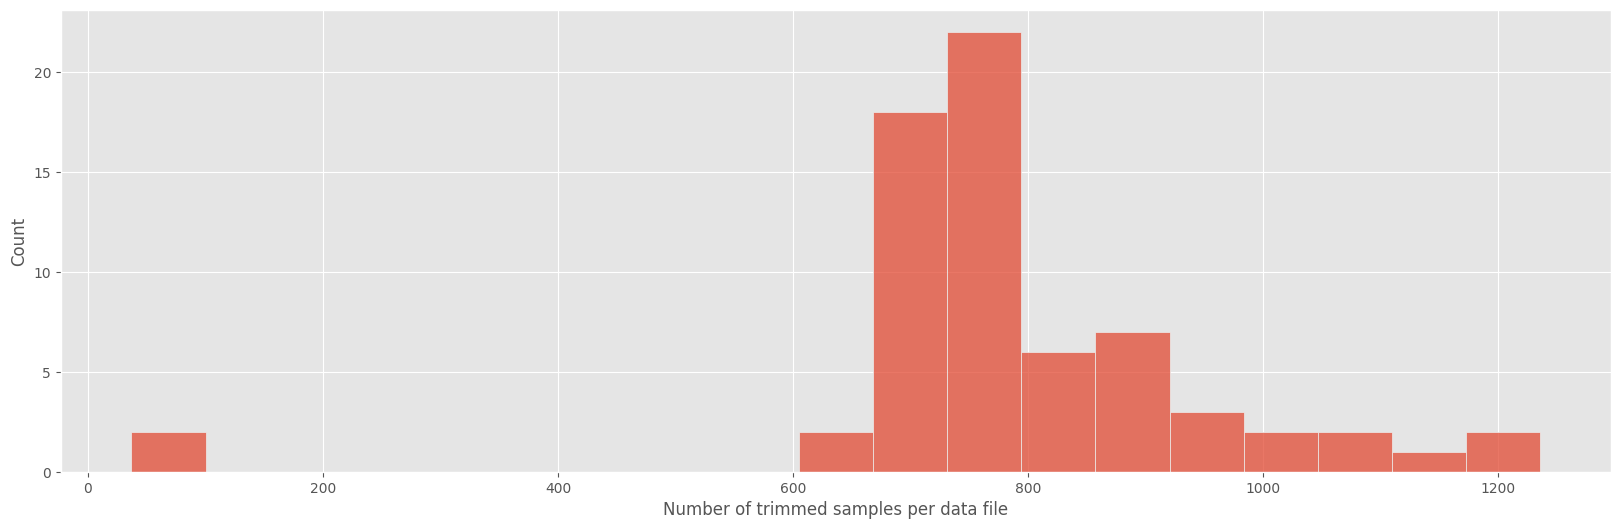

In [27]:
# Seaborn kernel density plot
sns.histplot(data=trimmings_array, fill=True)
plt.xlabel("Number of trimmed samples per data file")
# output/trimmed_samples.png

# Check values in trimmings_array < 0
print(trimmings_array[trimmings_array < 0])

### Aligning of data sources

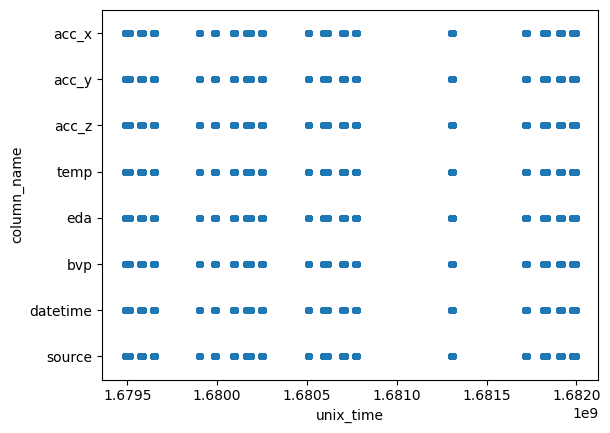

<Figure size 3000x1000 with 0 Axes>

In [3]:
# chunk_size = 100000  # Adjust this value based on your available memory
# chunks = [x for x in range(0, df.shape[0], chunk_size)]

# df_melted = pd.DataFrame()

# for i in range(len(chunks) - 1):
#     df_chunk = df.iloc[chunks[i]:chunks[i + 1]]
#     df_melted_chunk = df_chunk.melt(id_vars='unix_time', var_name='column_name')
#     df_melted = pd.concat([df_melted, df_melted_chunk])

# # Last chunk
# df_chunk = df.iloc[chunks[-1]:]
# df_melted_chunk = df_chunk.melt(id_vars='unix_time', var_name='column_name')
# df_melted = pd.concat([df_melted, df_melted_chunk])

# # Store df_melted as pickle
# with open('output/empatica_melted.pkl', 'wb') as f:
#     pickle.dump(df_melted, f)

# Load df_melted from pickle
with open('output/empatica_melted.pkl', 'rb') as f:
    df_melted = pickle.load(f)

sns.stripplot(x='unix_time', y='column_name', data=df_melted, jitter=False)
plt.figure(figsize=(30, 10))
plt.show()
# output/data_source_alignment.png

## Statistical properties

In [98]:
df['source'] = df['source'].astype(str)
print(df.info())
print(df.describe())

print(ibi_df.info())
print(ibi_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 12413182 entries, 0 to 94719
Data columns (total 10 columns):
 #   Column     Dtype         
---  ------     -----         
 0   acc_x      float64       
 1   acc_y      float64       
 2   acc_z      float64       
 3   temp       float64       
 4   eda        float64       
 5   bvp        float64       
 6   hr         float64       
 7   datetime   datetime64[ns]
 8   unix_time  float64       
 9   source     object        
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 1.0+ GB
None
            acc_x       acc_y       acc_z        temp         eda         bvp  \
count 12413182.00 12413182.00 12413182.00 12413182.00 12413182.00 12413182.00   
mean       -12.07        2.32       49.22       30.22        0.89       -0.00   
min       -174.29     -147.62     -165.11       20.12       -0.27    -2198.92   
25%        -37.04       -3.94       45.54       28.39        0.27      -17.02   
50%        -17.62        1.00       56.0

## Uniqueness

- No duplicate files.

In [8]:
print(uniqueness_check_df[uniqueness_check_df.duplicated(subset=['file_name', 'starting_time', 'ending_time'], keep=False)])

Empty DataFrame
Columns: [file_path, file_name, starting_time, ending_time]
Index: []


## Missing data

- No missing data

In [28]:
# Check for missing data in df
print(df.isnull().sum())

acc_x          0
acc_y          0
acc_z          0
temp           0
eda            0
bvp            0
hr           576
datetime       0
unix_time      0
source         0
dtype: int64


In [4]:
df.to_csv('output/empatica_raw.csv', index=False)
ibi_df.to_csv('output/empatica_ibi.csv', index=False)